<a href="https://colab.research.google.com/github/ndbellew/KompyuterM3chakrs/blob/master/Tensorflow-Keras/OverFitting_UnderFitting_TensorFlow_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overfitting and Underfitting

> Preiviously after training and testing enough we saw that the training error would constantly grow lower, but the testing error would top out somewhere. This is where we begin the discussion of overfitting.

* __Overfitting__ This occurs when there is far more epochs than is required to get the best possible prediction for the amount of datasets we are given. In short overfitting shows a lack of efficiency within the training. 

* __UnderFitting__ This is the opposite of Overfitting, where the model has not produced the  best possible predictions for the Network. This can happen for a number of reasons:
  * If the model is not powerful enough
  * The model is over-regularized
  * it has not been trained long enough. 

* __Regularization__: This places constraints on the quantity and type of information your model can store. CAUTION if used too frequently, could cause underfitting. 
 
As you train the model, you run into the threat of overtraining and undertraining, that is why the regression tutorial was an important stepping stone. 

To prevent Overfitting the best solution is to use more training data. This is the best way because it helps prevent Overfitting but also allows for higher and higher accuracy in future tests. Now if that is not possible, don't fret, we can also use techniques like _regularization_. If a network can only afford to memorize a small number of patters, the optimazation process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

This notebook will explore the 2 types of Regularization
1. Weight Regularization
2. Dropout



## Base Setup
### Imports

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.14.0


### Dataset Downloads
This will be using the IMDB dataset.
> This model will quickly overfit to the training set so that this can be used to show what overfitting looks like and how to fight it.

What we will do is multi-hot encode the sentences. 
__Multi-hot Encode__: turning given lists into vectors of 0s and 1s. 
This would mean a sequence like [3, 5] would become a 10,000-dimension vector that be all-zeroes except for 3 and 5. 

In [4]:
NUM_WORDS = 10000

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

def multi_hot_sequences(sequences, dimension):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # set specific indices of results[i] to 1s
    return results


train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

17465344/17464789 [==============================] - 0s 0us/step


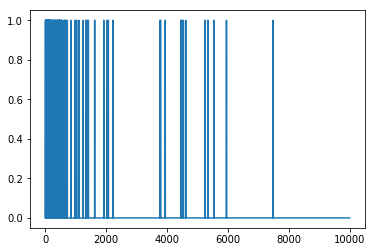

In [5]:
# Behold the Multi-hot vectors
plt.plot(train_data[0])

## Demonstrating Overfitting

The simplest way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters in the model (which is determined by the number of layers and the number of units per layer). The number of learnable parameters within a model is often referred to as _Capacity_. Intuitively, a model with more parameters will have more _Memorization Capacity_ and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets. This mapping would not require generaliztion power but would be useless for predicting data that has not been seen... which is the goal.

> Always remember, in deep learning models tend to be good at fitting to training data, but we are trying to create Generalization for our testing data.

If the network has limited memorization resources, it will not be able to learn mapping easily. In order to minimize loss, the model will have to learn compressed representations that have more predictive power. However, if you make your model too small, it will have difficultyfitting to the training data. It is the balance between too much and not enough capacity that you have to focus on. 

Currently there is no set formual that determines the correct amount, it is more-or-less guess-and-check based solutions. 

To find an appropiate model size, it is best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss. 




### Create Baseline Model
Lets use a simple model with jsut some _Dense_ layers. 

In [6]:
baseline_model = keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

baseline_model.summary()

W0717 18:58:26.303068 139839186093952 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0717 18:58:26.436487 139839186093952 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [7]:
baseline_history = baseline_model.fit(train_data,
                                      train_labels,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_data, test_labels),
                                      verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 4s - loss: 0.5238 - acc: 0.7900 - binary_crossentropy: 0.5238 - val_loss: 0.3648 - val_acc: 0.8701 - val_binary_crossentropy: 0.3648
Epoch 2/20
25000/25000 - 4s - loss: 0.2692 - acc: 0.9060 - binary_crossentropy: 0.2692 - val_loss: 0.2857 - val_acc: 0.8874 - val_binary_crossentropy: 0.2857
Epoch 3/20
25000/25000 - 3s - loss: 0.1888 - acc: 0.9306 - binary_crossentropy: 0.1888 - val_loss: 0.2887 - val_acc: 0.8852 - val_binary_crossentropy: 0.2887
Epoch 4/20
25000/25000 - 3s - loss: 0.1519 - acc: 0.9472 - binary_crossentropy: 0.1519 - val_loss: 0.3140 - val_acc: 0.8766 - val_binary_crossentropy: 0.3140
Epoch 5/20
25000/25000 - 4s - loss: 0.1257 - acc: 0.9578 - binary_crossentropy: 0.1257 - val_loss: 0.3298 - val_acc: 0.8764 - val_binary_crossentropy: 0.3298
Epoch 6/20
25000/25000 - 3s - loss: 0.1056 - acc: 0.9668 - binary_crossentropy: 0.1056 - val_loss: 0.3570 - val_acc: 0.8726 - val_binary_crossentropy: 0.3570
Ep

### Create a Smaller Model
This will be to compare to the other model. 

In [8]:
smaller_model = keras.Sequential([
    keras.layers.Dense(4, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

smaller_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', 'binary_crossentropy'])

smaller_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [9]:
smaller_history = smaller_model.fit(train_data,
                                    train_labels,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(test_data, test_labels),
                                    verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 6s - loss: 0.6570 - acc: 0.5757 - binary_crossentropy: 0.6570 - val_loss: 0.6172 - val_acc: 0.7139 - val_binary_crossentropy: 0.6172
Epoch 2/20
25000/25000 - 5s - loss: 0.5691 - acc: 0.7607 - binary_crossentropy: 0.5691 - val_loss: 0.5470 - val_acc: 0.7869 - val_binary_crossentropy: 0.5470
Epoch 3/20
25000/25000 - 6s - loss: 0.5009 - acc: 0.8361 - binary_crossentropy: 0.5009 - val_loss: 0.5002 - val_acc: 0.8402 - val_binary_crossentropy: 0.5002
Epoch 4/20
25000/25000 - 6s - loss: 0.4536 - acc: 0.8778 - binary_crossentropy: 0.4536 - val_loss: 0.4704 - val_acc: 0.8574 - val_binary_crossentropy: 0.4704
Epoch 5/20
25000/25000 - 5s - loss: 0.4185 - acc: 0.9011 - binary_crossentropy: 0.4185 - val_loss: 0.4504 - val_acc: 0.8675 - val_binary_crossentropy: 0.4504
Epoch 6/20
25000/25000 - 6s - loss: 0.3902 - acc: 0.9171 - binary_crossentropy: 0.3902 - val_loss: 0.4374 - val_acc: 0.8697 - val_binary_crossentropy: 0.4374
Ep

### Create a bigger Model
The smaller model will help show underfitting while a bigger model can help show overfitting. 

In [10]:
bigger_model = keras.models.Sequential([
    keras.layers.Dense(512, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

bigger_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy','binary_crossentropy'])

bigger_model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


In [11]:
#WE will train this behomoth with the same data as before

bigger_history = bigger_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 32s - loss: 0.3471 - acc: 0.8494 - binary_crossentropy: 0.3471 - val_loss: 0.3061 - val_acc: 0.8739 - val_binary_crossentropy: 0.3061
Epoch 2/20
25000/25000 - 31s - loss: 0.1498 - acc: 0.9448 - binary_crossentropy: 0.1498 - val_loss: 0.3291 - val_acc: 0.8724 - val_binary_crossentropy: 0.3291
Epoch 3/20
25000/25000 - 32s - loss: 0.0536 - acc: 0.9838 - binary_crossentropy: 0.0536 - val_loss: 0.4424 - val_acc: 0.8674 - val_binary_crossentropy: 0.4424
Epoch 4/20
25000/25000 - 32s - loss: 0.0091 - acc: 0.9982 - binary_crossentropy: 0.0091 - val_loss: 0.6116 - val_acc: 0.8632 - val_binary_crossentropy: 0.6116
Epoch 5/20
25000/25000 - 31s - loss: 0.0016 - acc: 0.9999 - binary_crossentropy: 0.0016 - val_loss: 0.6998 - val_acc: 0.8688 - val_binary_crossentropy: 0.6998
Epoch 6/20
25000/25000 - 31s - loss: 5.1893e-04 - acc: 0.9999 - binary_crossentropy: 5.1893e-04 - val_loss: 0.7478 - val_acc: 0.8679 - val_binary_crossentr

### Plotting
Now we need to plot the training and validation loss from the model. 
We will use solid lines to show the training loss and dashed lines to show the validation loss. 
> Remember a lower validation loss indicates a better model. The reason we are showing the training loss is to prove the over/under-fitting of the model(s) we have created. 

Here the smaller network begins overfitting latern than the baseline and its performace degrades much more slowly once it begins to overfit. 

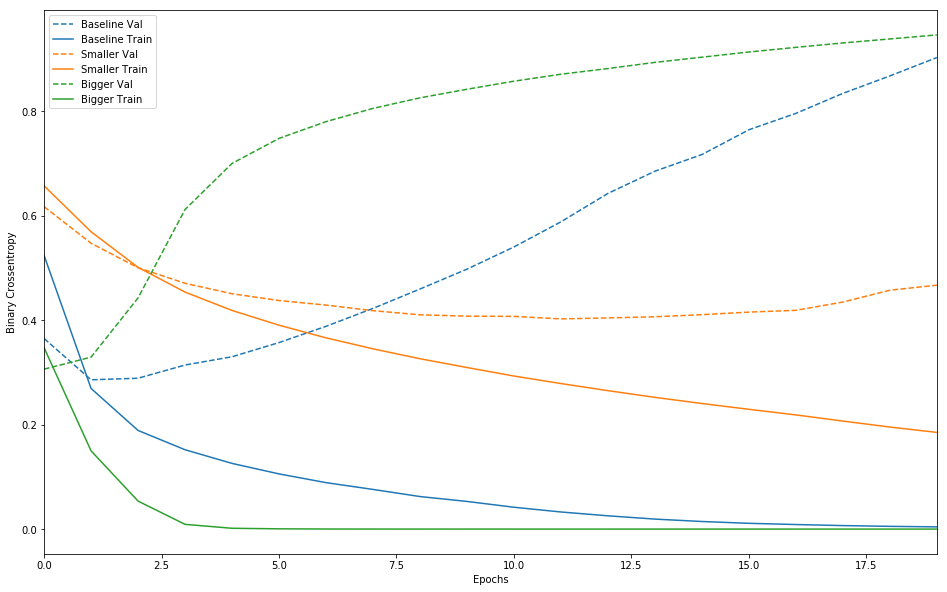

In [12]:
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('baseline', baseline_history),
              ('smaller', smaller_history),
              ('bigger', bigger_history)])

A lot of strange things goin on here.

So if you notice the larger network begins overfitting right away, after only a single epoch, and then continues to overfit drastically. The higher capacity the network has, the quicker it will be able to model the training data (this will result in low training loss), but the more susceptible it will be to overfitting (resulting in a large difference between the training and validation loss)

## Strategies

### Add Weight Regularization
Obviously you are all familiar with _Occam's Razor_ principle
> given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions.

Occam's Razor also applies to the models learned by our neural networks
> If we are given some training data and some network architecture, there will be multiple sets of weights values (multiple models) that could explain the data, so that the simpler models will be less likely to overfit than complex ones.

* __simple model__: at least for this context, a simple modle is where the distribution of parameter value has less entropy ( or rather a model with fewer parameters altogether, as we saw int he section above). 
* __weight regularization__: A common way to mitigate overfitting is to place constraings on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more _regular_. 

Essentially we will be looking for how to create a _simple model_. A way to create a simple model is to use weight regularization, this can be down by adding to the loss function of the network, a cost associated with having large weights. This comes in 2 flavors:

1. __L1 Regularization__: A type of regularization that penalizes weights in proportion to the sum of the absolute values of the weights. In models relying on sparse features, L1 regularization helps drive the weights of irrelevant or barely relevant features to exactly 0, which removes those features from the model. Contrast with L2 regularization.

2. __L2 Regularization__: A type of regularization that penalizes weights in proportion to the sum of the squares of the weights. L2 regularization helps drive outlier weights (those with high positive or low negative values) closer to 0 but not quite to 0. (Contrast with L1 regularization.) L2 regularization always improves generalization in linear models.

In Keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments.


In [13]:
l2_model = keras.models.Sequential([
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

l2_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])

l2_model_history = l2_model.fit(train_data, train_labels,
                                epochs=20,
                                batch_size=512,
                                validation_data=(test_data, test_labels),
                                verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 6s - loss: 0.6031 - acc: 0.7002 - binary_crossentropy: 0.5684 - val_loss: 0.4653 - val_acc: 0.8599 - val_binary_crossentropy: 0.4313
Epoch 2/20
25000/25000 - 6s - loss: 0.3512 - acc: 0.9042 - binary_crossentropy: 0.3117 - val_loss: 0.3420 - val_acc: 0.8886 - val_binary_crossentropy: 0.2972
Epoch 3/20
25000/25000 - 6s - loss: 0.2593 - acc: 0.9294 - binary_crossentropy: 0.2105 - val_loss: 0.3422 - val_acc: 0.8842 - val_binary_crossentropy: 0.2905
Epoch 4/20
25000/25000 - 6s - loss: 0.2293 - acc: 0.9414 - binary_crossentropy: 0.1751 - val_loss: 0.3659 - val_acc: 0.8765 - val_binary_crossentropy: 0.3098
Epoch 5/20
25000/25000 - 6s - loss: 0.2084 - acc: 0.9503 - binary_crossentropy: 0.1510 - val_loss: 0.3766 - val_acc: 0.8758 - val_binary_crossentropy: 0.3180
Epoch 6/20
25000/25000 - 6s - loss: 0.1937 - acc: 0.9584 - binary_crossentropy: 0.1341 - val_loss: 0.3900 - val_acc: 0.8731 - val_binary_crossentropy: 0.3296
Ep

so this __12(0.001)__ means that every coefficient in the weight matrix of the layer will add __0.001 * weight_coefficient_value**2__ to the total loss of the network. 

Note
> The penalty is only added at training time, the loss for this network will be much higher at training time than at testing time. 

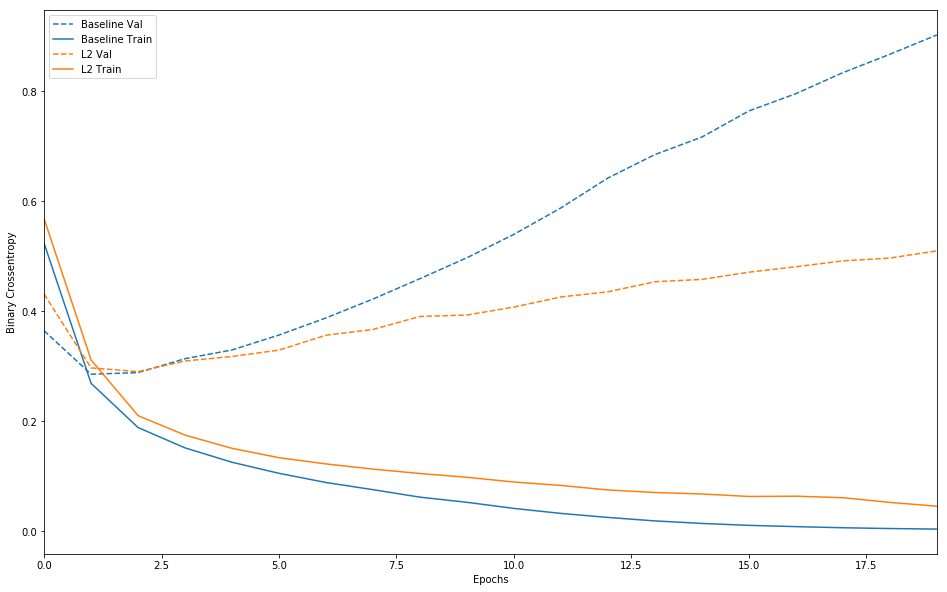

In [14]:
#Here is the mipoact of our L2 regularization penalty
plot_history([('baseline', baseline_history),
              ('l2', l2_model_history)])

You can see here that the _L2 Regularized Model_ has become much more resistant to overfitting than the baseline model, even though both models have the same number of parameters. 


### Add Dropout

Droput is one of the most effective and most comonly used regularization techniques for neural networks.  
__Dropout__: usually applied to a layer and consists of randomly "dropping out" a number of output features of the layer during training. 
Dropout example:
> Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 1.3, 0, 1.1]. The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

in Keras you can introduce dropout in a network via the Dropout layer, which gets applied to the output layer right before. 

Lets try this out on our own model. 

In [15]:
dpt_model = keras.models.Sequential([
    keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

dpt_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy','binary_crossentropy'])

dpt_model_history = dpt_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 7s - loss: 0.6308 - acc: 0.6393 - binary_crossentropy: 0.6308 - val_loss: 0.5191 - val_acc: 0.8356 - val_binary_crossentropy: 0.5191
Epoch 2/20
25000/25000 - 5s - loss: 0.4856 - acc: 0.8078 - binary_crossentropy: 0.4856 - val_loss: 0.3926 - val_acc: 0.8804 - val_binary_crossentropy: 0.3926
Epoch 3/20
25000/25000 - 5s - loss: 0.3872 - acc: 0.8709 - binary_crossentropy: 0.3872 - val_loss: 0.3292 - val_acc: 0.8810 - val_binary_crossentropy: 0.3292
Epoch 4/20
25000/25000 - 5s - loss: 0.3167 - acc: 0.9014 - binary_crossentropy: 0.3167 - val_loss: 0.2951 - val_acc: 0.8842 - val_binary_crossentropy: 0.2951
Epoch 5/20
25000/25000 - 5s - loss: 0.2679 - acc: 0.9172 - binary_crossentropy: 0.2679 - val_loss: 0.2946 - val_acc: 0.8880 - val_binary_crossentropy: 0.2946
Epoch 6/20
25000/25000 - 5s - loss: 0.2339 - acc: 0.9288 - binary_crossentropy: 0.2339 - val_loss: 0.2901 - val_acc: 0.8822 - val_binary_crossentropy: 0.2901
Ep

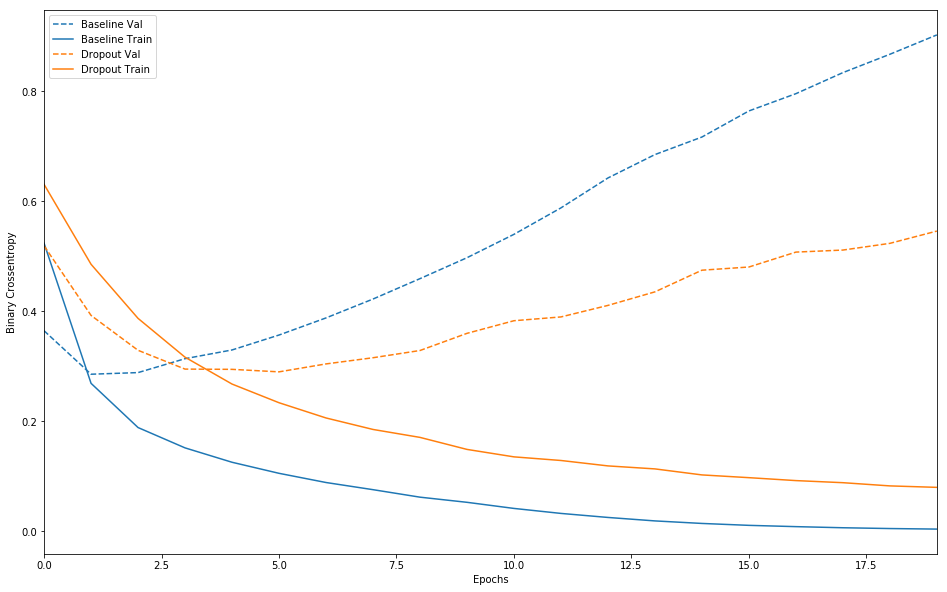

In [16]:
plot_history([('baseline', baseline_history),
              ('dropout', dpt_model_history)])

Adding dropout is a clear improvement over the baseline model.

__Recap__ The most common ways to prevent overfitting in neural networks are:
* get more training data
* reduce capacity of the network
* add weight regularization
* add dropout

and two important approaches (that were not covered) are 
1. Data-augmentation
2. batch normalization

In [0]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.